In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm  # 导入tqdm库
import warnings  # 避免一些可以忽略的报错
warnings.filterwarnings('ignore')  # 过滤警告信息
plt.rcParams['font.sans-serif'] = ['SimHei']  # 正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 加载数据
df = pd.read_csv("D:\\Documents\\cluener_public\\MSFT(2000-2023).csv")
print(f"len(df): {len(df)}")    
df.head()


len(df): 6012


,Date,Open,High,Low,Close,Adj Close,Volume
0,1/3/2000,58.68750,59.3125,56.00000,58.28125,36.132248,53228400
1,1/4/2000,56.78125,58.5625,56.12500,56.31250,34.911709,54119000
2,1/5/2000,55.56250,58.1875,54.68750,56.90625,35.279816,64059600
3,1/6/2000,56.09375,56.9375,54.18750,55.00000,34.098019,54976600
4,1/7/2000,54.31250,56.1250,53.65625,55.71875,34.543629,62013600


In [ ]:
df.shape

Close: 6012


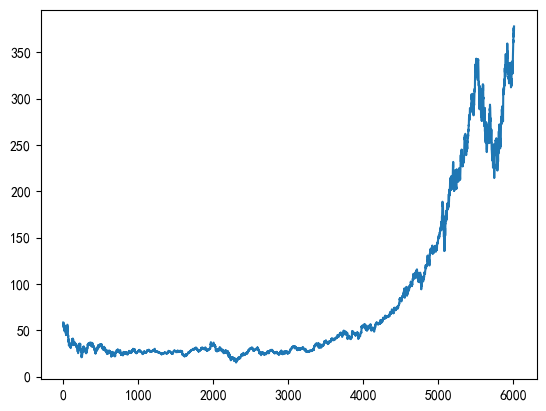

In [2]:
# 提取收盘价数据
Close = df['Close'].values
print(f"Close: {len(Close)}")        # Close:1511

# 绘制收盘价变化图
plt.plot([i for i in range(len(Close))], Close)

In [ ]:
# 选择相关的列，数据列名为：['Date', 'Open', 'High', 'Low', 'Close']
df = df[['Date', 'Open', 'High', 'Low', 'Close']]

# 转换日期为日期类型
df['Date'] = pd.to_datetime(df['Date'])

# 使用 MinMaxScaler 归一化数据
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']])

# 设置时间窗口 (Sequence Length)
seq_length = 3  # 过去3天的数据来预测当天的收盘价

# 数据划分函数
def split_data(data, seq_length):
    dataX = []
    datay = []
    for i in range(len(data)-seq_length):
        dataX.append(data[i:i+seq_length])
        datay.append(data[i+seq_length, 3])  # 收盘价是目标数据（归一化后对应第4列）
    dataX = np.array(dataX).reshape(len(dataX), seq_length, -1)
    datay = np.array(datay).reshape(len(dataX), -1)
    return np.array(dataX), np.array(datay)

# 创建数据集
dataX, datay = split_data(scaled_data, seq_length)
print(f"dataX.shape: {dataX.shape}, datay.shape: {datay.shape}")


In [ ]:
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size=0.2, shuffle=False)
print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(y_test, dtype=torch.float32)

# 打印训练集输入张量的形状
print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)

# 创建训练数据集和加载器
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# 创建测试数据集和加载器
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# LSTM 模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, output_size=1, num_layers=3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 初始化记忆状态c0
        out, _ = self.lstm(x, (h0, c0))  # 仅返回最后一个时间步的输出
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out
    
# 初始化模型
model = LSTMModel(input_size=4, hidden_size=64, output_size=1, num_layers=1)


In [ ]:
for x_train, y_train in train_loader:
    print(x_train.shape)
    print(y_train.shape)
    break

In [82]:
# 训练模型
criterion = nn.MSELoss()  # 使用均方误差损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50  # 设置训练轮数
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    
    for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", ncols=100):
        x_train, y_train = x_train, y_train
        optimizer.zero_grad()  # 清空梯度
        y_train_pred = model(x_train)  # 模型预测
        loss = criterion(y_train_pred, y_train)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        running_train_loss += loss.item() * x_train.size(0)  # 累加训练损失
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # 验证集评估
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test, y_test
            y_test_pred = model(x_test)  # 模型预测
            loss = criterion(y_test_pred, y_test)  # 计算损失
            running_val_loss += loss.item() * x_test.size(0)  # 累加验证损失
    
    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


Epoch 50/50 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 362.99it/s]

Epoch 50/50, Train Loss: 0.0011, Validation Loss: 0.0032


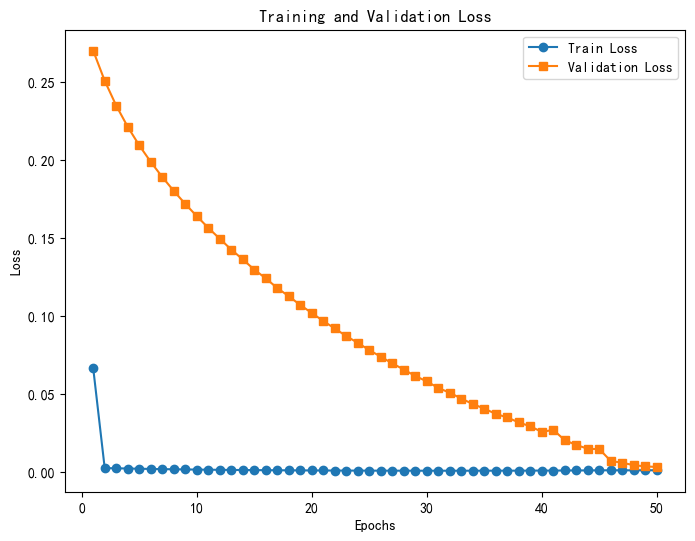

In [83]:
# 绘制训练和验证损失曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


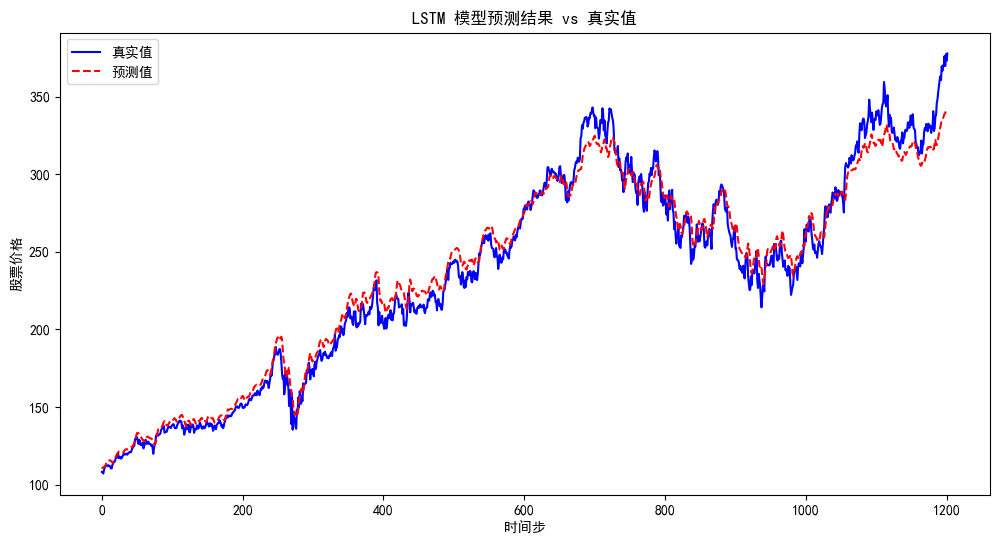

In [84]:

# 获取模型预测值并反归一化
predictions = model(X_test).detach().numpy().reshape(-1, 1)
real_values = Y_test.detach().numpy().reshape(-1, 1)

# 将 predictions 和 real_values 转换为 (302, 4) 的数组，填充前三列为零
predictions = np.column_stack([np.zeros((predictions.shape[0], 3)), predictions])  # 填充前三列为零
real_values = np.column_stack([np.zeros((real_values.shape[0], 3)), real_values])  # 填充前三列为零

# 反归一化
predictions = scaler.inverse_transform(predictions)[:, 3]  # 提取最后一列（即收盘价）
real_values = scaler.inverse_transform(real_values)[:, 3]  # 提取最后一列（即收盘价）

# 绘制预测结果与真实值
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='真实值', color='blue')
plt.plot(predictions, label='预测值', color='red', linestyle='dashed')
plt.xlabel('时间步')
plt.ylabel('股票价格')
plt.title('LSTM 模型预测结果 vs 真实值')
plt.legend()
plt.show()


In [3]:
# 选择相关的列，数据列名为：['Date', 'Open', 'High', 'Low', 'Close']
df = df[['Date', 'Open', 'High', 'Low', 'Close']]

# 转换日期为日期类型
df['Date'] = pd.to_datetime(df['Date'])

# 使用 MinMaxScaler 归一化数据
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']])
scaled_data[:3]

array([[-0.76026736, -0.76004339, -0.77156346, -0.76216571],
       [-0.77077591, -0.76416235, -0.7708692 , -0.77302178],
       [-0.77749449, -0.76622183, -0.7788531 , -0.76974773]])

In [4]:

# 设置时间窗口 (Sequence Length)
seq_length = 3  # 过去3天的数据来预测当天的收盘价

# 数据划分函数
def split_data(data, seq_length):
    dataX = []
    datay = []
    for i in range(len(data)-seq_length):
        dataX.append(data[i:i+seq_length,3])
        datay.append(data[i+seq_length, 3])  # 收盘价是目标数据（归一化后对应第4列）
    dataX = np.array(dataX).reshape(len(dataX), seq_length, -1)
    datay = np.array(datay).reshape(len(dataX), -1)
    return np.array(dataX), np.array(datay)

# 创建数据集
dataX, datay = split_data(scaled_data, seq_length)
print(f"dataX.shape: {dataX.shape}, datay.shape: {datay.shape}")


dataX.shape: (6009, 3, 1), datay.shape: (6009, 1)


In [5]:
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size=0.2, shuffle=False)
print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(y_test, dtype=torch.float32)

# 打印训练集输入张量的形状
print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)

# 创建训练数据集和加载器
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# 创建测试数据集和加载器
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


X_train.shape: (4807, 3, 1), X_test.shape: (1202, 3, 1)
X_train:  torch.Size([4807, 3, 1])
Y_train:  torch.Size([4807, 1])


In [12]:
# LSTM 模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 初始化记忆状态c0
        out, _ = self.lstm(x, (h0, c0))  # 仅返回最后一个时间步的输出
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out
    
# 初始化模型
model = LSTMModel(input_size=1, hidden_size=64, output_size=1, num_layers=1)


In [13]:
for x_train, y_train in train_loader:
    print(x_train.shape)
    print(y_train.shape)
    print(x_train[0])
    print(y_train[0])
    
    break

torch.Size([32, 3, 1])
torch.Size([32, 1])
tensor([[-0.7622],
        [-0.7730],
        [-0.7697]])
tensor([-0.7803])


In [14]:
# 训练模型
criterion = nn.MSELoss()  # 使用均方误差损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100  # 设置训练轮数
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    
    for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", ncols=100):
        x_train, y_train = x_train, y_train
        optimizer.zero_grad()  # 清空梯度
        y_train_pred = model(x_train)  # 模型预测
        loss = criterion(y_train_pred, y_train)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        running_train_loss += loss.item() * x_train.size(0)  # 累加训练损失
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # 验证集评估
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test, y_test
            y_test_pred = model(x_test)  # 模型预测
            loss = criterion(y_test_pred, y_test)  # 计算损失
            running_val_loss += loss.item() * x_test.size(0)  # 累加验证损失
    
    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


Epoch 1/100 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 278.60it/s]


Epoch 1/100, Train Loss: 0.0804, Validation Loss: 0.3856


Epoch 2/100 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 354.46it/s]


Epoch 2/100, Train Loss: 0.0042, Validation Loss: 0.3623


Epoch 3/100 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 375.62it/s]


Epoch 3/100, Train Loss: 0.0041, Validation Loss: 0.3472


Epoch 4/100 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 323.34it/s]


Epoch 4/100, Train Loss: 0.0040, Validation Loss: 0.3355


Epoch 5/100 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 387.16it/s]


Epoch 5/100, Train Loss: 0.0039, Validation Loss: 0.3257


Epoch 6/100 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 373.76it/s]


Epoch 6/100, Train Loss: 0.0038, Validation Loss: 0.3169


Epoch 7/100 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 374.69it/s]


Epoch 7/100, Train Loss: 0.0037, Validation Loss: 0.3088


Epoch 8/100 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 356.96it/s]


Epoch 8/100, Train Loss: 0.0036, Validation Loss: 0.3010


Epoch 9/100 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 350.85it/s]


Epoch 9/100, Train Loss: 0.0035, Validation Loss: 0.2932


Epoch 10/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 377.50it/s]


Epoch 10/100, Train Loss: 0.0035, Validation Loss: 0.2851


Epoch 11/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 380.35it/s]


Epoch 11/100, Train Loss: 0.0034, Validation Loss: 0.2784


Epoch 12/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 289.28it/s]


Epoch 12/100, Train Loss: 0.0033, Validation Loss: 0.2704


Epoch 13/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 382.28it/s]


Epoch 13/100, Train Loss: 0.0033, Validation Loss: 0.2648


Epoch 14/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 357.65it/s]


Epoch 14/100, Train Loss: 0.0032, Validation Loss: 0.2534


Epoch 15/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 362.98it/s]


Epoch 15/100, Train Loss: 0.0032, Validation Loss: 0.2490


Epoch 16/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 347.13it/s]


Epoch 16/100, Train Loss: 0.0031, Validation Loss: 0.2392


Epoch 17/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 321.96it/s]


Epoch 17/100, Train Loss: 0.0031, Validation Loss: 0.2306


Epoch 18/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 339.32it/s]


Epoch 18/100, Train Loss: 0.0030, Validation Loss: 0.2218


Epoch 19/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 351.65it/s]


Epoch 19/100, Train Loss: 0.0029, Validation Loss: 0.2111


Epoch 20/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 385.21it/s]


Epoch 20/100, Train Loss: 0.0028, Validation Loss: 0.2032


Epoch 21/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 383.26it/s]


Epoch 21/100, Train Loss: 0.0028, Validation Loss: 0.1887


Epoch 22/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 388.19it/s]


Epoch 22/100, Train Loss: 0.0027, Validation Loss: 0.1829


Epoch 23/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 374.69it/s]


Epoch 23/100, Train Loss: 0.0027, Validation Loss: 0.1710


Epoch 24/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 352.61it/s]


Epoch 24/100, Train Loss: 0.0026, Validation Loss: 0.1593


Epoch 25/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 335.56it/s]


Epoch 25/100, Train Loss: 0.0025, Validation Loss: 0.1470


Epoch 26/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 372.84it/s]


Epoch 26/100, Train Loss: 0.0024, Validation Loss: 0.1359


Epoch 27/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 379.40it/s]


Epoch 27/100, Train Loss: 0.0024, Validation Loss: 0.1192


Epoch 28/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 342.32it/s]


Epoch 28/100, Train Loss: 0.0022, Validation Loss: 0.1144


Epoch 29/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 368.77it/s]


Epoch 29/100, Train Loss: 0.0022, Validation Loss: 0.0952


Epoch 30/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 393.23it/s]


Epoch 30/100, Train Loss: 0.0021, Validation Loss: 0.0847


Epoch 31/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 332.60it/s]


Epoch 31/100, Train Loss: 0.0020, Validation Loss: 0.0697


Epoch 32/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 370.10it/s]


Epoch 32/100, Train Loss: 0.0019, Validation Loss: 0.0579


Epoch 33/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 346.26it/s]


Epoch 33/100, Train Loss: 0.0018, Validation Loss: 0.0428


Epoch 34/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 357.82it/s]


Epoch 34/100, Train Loss: 0.0017, Validation Loss: 0.0340


Epoch 35/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 374.68it/s]


Epoch 35/100, Train Loss: 0.0017, Validation Loss: 0.0206


Epoch 36/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 362.98it/s]


Epoch 36/100, Train Loss: 0.0015, Validation Loss: 0.0139


Epoch 37/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 384.22it/s]


Epoch 37/100, Train Loss: 0.0015, Validation Loss: 0.0061


Epoch 38/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 302.23it/s]


Epoch 38/100, Train Loss: 0.0014, Validation Loss: 0.0020


Epoch 39/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 385.18it/s]


Epoch 39/100, Train Loss: 0.0013, Validation Loss: 0.0013


Epoch 40/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 361.24it/s]


Epoch 40/100, Train Loss: 0.0013, Validation Loss: 0.0055


Epoch 41/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 393.23it/s]


Epoch 41/100, Train Loss: 0.0012, Validation Loss: 0.0050


Epoch 42/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 371.92it/s]


Epoch 42/100, Train Loss: 0.0013, Validation Loss: 0.0256


Epoch 43/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 361.19it/s]


Epoch 43/100, Train Loss: 0.0011, Validation Loss: 0.0213


Epoch 44/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 377.51it/s]


Epoch 44/100, Train Loss: 0.0013, Validation Loss: 0.0545


Epoch 45/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 308.80it/s]


Epoch 45/100, Train Loss: 0.0010, Validation Loss: 0.0443


Epoch 46/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 361.24it/s]


Epoch 46/100, Train Loss: 0.0013, Validation Loss: 0.0993


Epoch 47/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 373.77it/s]


Epoch 47/100, Train Loss: 0.0010, Validation Loss: 0.0506


Epoch 48/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 355.83it/s]


Epoch 48/100, Train Loss: 0.0015, Validation Loss: 0.1607


Epoch 49/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 389.18it/s]


Epoch 49/100, Train Loss: 0.0009, Validation Loss: 0.0498


Epoch 50/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 376.56it/s]


Epoch 50/100, Train Loss: 0.0016, Validation Loss: 0.1858


Epoch 51/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 372.84it/s]


Epoch 51/100, Train Loss: 0.0009, Validation Loss: 0.0582


Epoch 52/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 337.05it/s]


Epoch 52/100, Train Loss: 0.0018, Validation Loss: 0.2092


Epoch 53/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 363.89it/s]


Epoch 53/100, Train Loss: 0.0010, Validation Loss: 0.0928


Epoch 54/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 358.67it/s]


Epoch 54/100, Train Loss: 0.0018, Validation Loss: 0.2699


Epoch 55/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 359.52it/s]


Epoch 55/100, Train Loss: 0.0012, Validation Loss: 0.1332


Epoch 56/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 346.33it/s]


Epoch 56/100, Train Loss: 0.0019, Validation Loss: 0.3552


Epoch 57/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 350.50it/s]


Epoch 57/100, Train Loss: 0.0011, Validation Loss: 0.1737


Epoch 58/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 361.09it/s]


Epoch 58/100, Train Loss: 0.0019, Validation Loss: 0.4027


Epoch 59/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 317.23it/s]


Epoch 59/100, Train Loss: 0.0011, Validation Loss: 0.2075


Epoch 60/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 371.01it/s]


Epoch 60/100, Train Loss: 0.0020, Validation Loss: 0.4529


Epoch 61/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 378.45it/s]


Epoch 61/100, Train Loss: 0.0011, Validation Loss: 0.2237


Epoch 62/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 357.07it/s]


Epoch 62/100, Train Loss: 0.0021, Validation Loss: 0.5057


Epoch 63/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 386.19it/s]


Epoch 63/100, Train Loss: 0.0011, Validation Loss: 0.2324


Epoch 64/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 373.76it/s]


Epoch 64/100, Train Loss: 0.0022, Validation Loss: 0.5146


Epoch 65/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 341.64it/s]


Epoch 65/100, Train Loss: 0.0012, Validation Loss: 0.2502


Epoch 66/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 377.51it/s]


Epoch 66/100, Train Loss: 0.0022, Validation Loss: 0.5231


Epoch 67/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 351.84it/s]


Epoch 67/100, Train Loss: 0.0012, Validation Loss: 0.2784


Epoch 68/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 383.24it/s]


Epoch 68/100, Train Loss: 0.0022, Validation Loss: 0.5483


Epoch 69/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 378.45it/s]


Epoch 69/100, Train Loss: 0.0012, Validation Loss: 0.2835


Epoch 70/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 360.39it/s]


Epoch 70/100, Train Loss: 0.0022, Validation Loss: 0.5330


Epoch 71/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 358.67it/s]


Epoch 71/100, Train Loss: 0.0012, Validation Loss: 0.2839


Epoch 72/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 297.64it/s]


Epoch 72/100, Train Loss: 0.0023, Validation Loss: 0.5092


Epoch 73/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 387.18it/s]


Epoch 73/100, Train Loss: 0.0013, Validation Loss: 0.2989


Epoch 74/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 375.62it/s]


Epoch 74/100, Train Loss: 0.0022, Validation Loss: 0.4821


Epoch 75/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 372.84it/s]


Epoch 75/100, Train Loss: 0.0013, Validation Loss: 0.2738


Epoch 76/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 343.97it/s]


Epoch 76/100, Train Loss: 0.0023, Validation Loss: 0.5042


Epoch 77/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 359.36it/s]


Epoch 77/100, Train Loss: 0.0013, Validation Loss: 0.2692


Epoch 78/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 331.14it/s]


Epoch 78/100, Train Loss: 0.0023, Validation Loss: 0.4593


Epoch 79/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 370.10it/s]


Epoch 79/100, Train Loss: 0.0014, Validation Loss: 0.2654


Epoch 80/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 371.92it/s]


Epoch 80/100, Train Loss: 0.0022, Validation Loss: 0.3990


Epoch 81/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 370.10it/s]


Epoch 81/100, Train Loss: 0.0013, Validation Loss: 0.2319


Epoch 82/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 372.75it/s]


Epoch 82/100, Train Loss: 0.0023, Validation Loss: 0.3523


Epoch 83/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 384.23it/s]


Epoch 83/100, Train Loss: 0.0013, Validation Loss: 0.2106


Epoch 84/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 367.38it/s]


Epoch 84/100, Train Loss: 0.0022, Validation Loss: 0.3104


Epoch 85/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 328.97it/s]


Epoch 85/100, Train Loss: 0.0014, Validation Loss: 0.1978


Epoch 86/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 368.57it/s]


Epoch 86/100, Train Loss: 0.0021, Validation Loss: 0.2741


Epoch 87/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 362.09it/s]


Epoch 87/100, Train Loss: 0.0014, Validation Loss: 0.1704


Epoch 88/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 380.35it/s]


Epoch 88/100, Train Loss: 0.0021, Validation Loss: 0.2320


Epoch 89/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 373.76it/s]


Epoch 89/100, Train Loss: 0.0014, Validation Loss: 0.1496


Epoch 90/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 389.17it/s]


Epoch 90/100, Train Loss: 0.0021, Validation Loss: 0.2019


Epoch 91/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 377.50it/s]


Epoch 91/100, Train Loss: 0.0014, Validation Loss: 0.1281


Epoch 92/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 291.84it/s]


Epoch 92/100, Train Loss: 0.0021, Validation Loss: 0.1706


Epoch 93/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 390.17it/s]


Epoch 93/100, Train Loss: 0.0014, Validation Loss: 0.1060


Epoch 94/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 391.17it/s]


Epoch 94/100, Train Loss: 0.0020, Validation Loss: 0.1360


Epoch 95/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 368.29it/s]


Epoch 95/100, Train Loss: 0.0015, Validation Loss: 0.0920


Epoch 96/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 364.38it/s]


Epoch 96/100, Train Loss: 0.0019, Validation Loss: 0.1027


Epoch 97/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 372.91it/s]


Epoch 97/100, Train Loss: 0.0016, Validation Loss: 0.0774


Epoch 98/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 384.22it/s]


Epoch 98/100, Train Loss: 0.0017, Validation Loss: 0.0716


Epoch 99/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 371.01it/s]


Epoch 99/100, Train Loss: 0.0018, Validation Loss: 0.0650


Epoch 100/100 - Training: 100%|██████████████████████████████████| 151/151 [00:00<00:00, 384.23it/s]

Epoch 100/100, Train Loss: 0.0016, Validation Loss: 0.0549


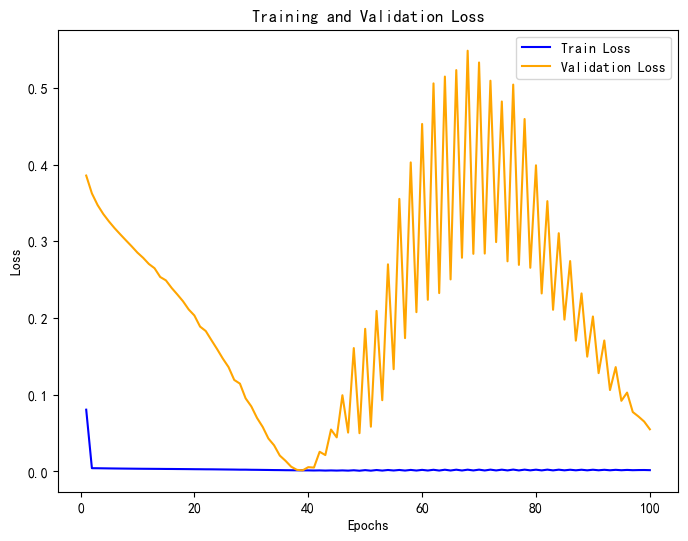

In [15]:
# 绘制训练和验证损失曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss',color = "blue")
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss',color = "orange")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training and Validation Loss')
plt.legend()


In [16]:

# 获取模型预测值并反归一化
predictions = model(X_test).detach().numpy().reshape(-1, 1)
real_values = Y_test.detach().numpy().reshape(-1, 1)

# 将 predictions 和 real_values 转换为 (302, 4) 的数组，填充前三列为零
predictions = np.column_stack([np.zeros((predictions.shape[0], 3)), predictions])  # 填充前三列为零
real_values = np.column_stack([np.zeros((real_values.shape[0], 3)), real_values])  # 填充前三列为零


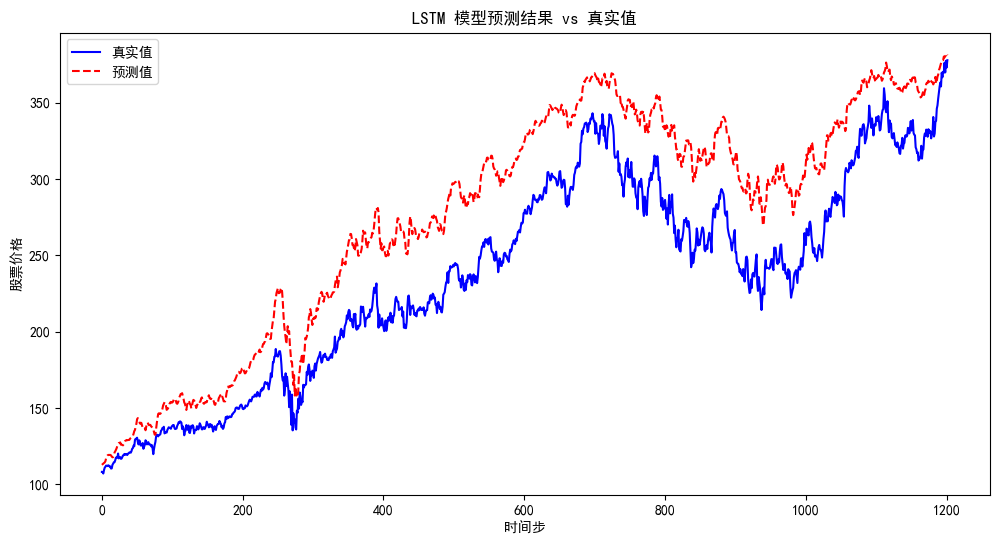

In [17]:

# 反归一化
predictions = scaler.inverse_transform(predictions)[:, 3]  # 提取最后一列（即收盘价）
real_values = scaler.inverse_transform(real_values)[:, 3]  # 提取最后一列（即收盘价）

# 绘制预测结果与真实值
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='真实值', color='blue')
plt.plot(predictions, label='预测值', color='red', linestyle='dashed')
plt.xlabel('时间步')
plt.ylabel('股票价格')
plt.title('LSTM 模型预测结果 vs 真实值')
plt.legend()
plt.show()
